#2 Feed-Forward Neural Network.

In [ ]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle

In [ ]:
mnist = load_digits()

Viewing Data

In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
mnist.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
mnist.data.shape

(1797, 64)

In [ ]:
mnist.target.shape

(1797,)

In [ ]:
pd.DataFrame(mnist.data).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [ ]:
pd.DataFrame(mnist.target).head()

,0
0,0
1,1
2,2
3,3
4,4


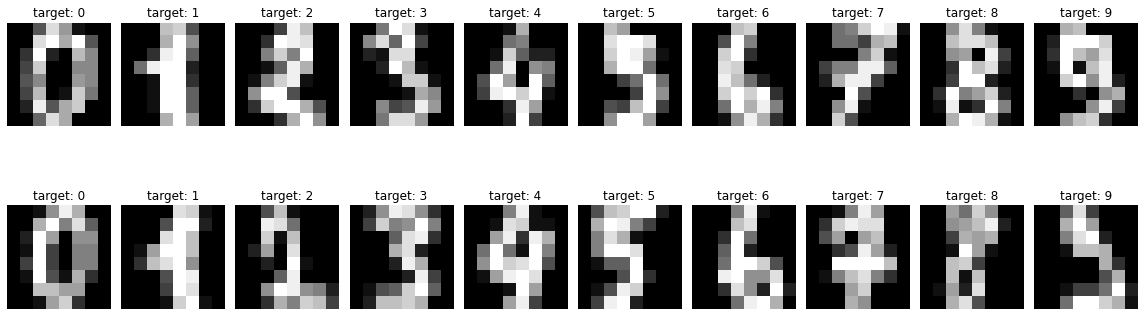

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")

plt.tight_layout()

In [ ]:
#FUNCTION FOR NORMALIZING THE DATA

def normalize_data(data):
    normalized_data = np.zeros((data.shape))
    for i in range(data.shape[0]):
         img = data[i,:]
         image = (img - np.min(img))/(np.ptp(img))
         normalized_data[i,:] =  image
    return normalized_data

In [ ]:
#FUNCTION FOR CONVERTING TARGETS INTO ONE HOT ENCODING

def one_hot(y):
    table = np.zeros((y.shape[0], 10))
    for i in range(y.shape[0]):
      val = y[i]
      for row in range(10):
        if (val==row):
          table[i,val]=1
    return table

In [ ]:
#ACTIVATION FUNCTIONS & THEIR DERIVATIVES

def tanh(a):
    return np.tanh(a)

def tanh_derivative(a):
   return (1-np.tanh(a)**2)

def relu(a):
    return np.maximum(0, a)

def relu_derivative(a):
    a[a<=0] = 0
    a[a>0] = 1
    return a

def softmax(a):
    e = np.exp(a-a.max())
    output = e / np.sum(e, axis=0)
    return output

def softmax_derivative(a):
    e = np.exp(a-a.max())
    return e / np.sum(e, axis=0) * (1 - e / np.sum(e, axis=0))

In [ ]:

#NEURAL NETWORK CLASS

"""
FUNCTIONS:

initialize_parameters: initializes weights & biases

fprop: forward propogation

        a = w T x + b
        z = activation_func(a)

calculate_loss: cross entropy loss for multi-class classification

bprop: backward propogation - to calculate gradients

        if final layer:
          delta = predicted_y - target
        else:
          delta = derivative_of_activation_func * weight * delta_of_next_layer

      dL/dW = delta * input
      dL/db = summation(delta)

update_parameters: W = W - learning_rate * dL/dW
                   b = b - learning_rate * dL/db
"""


class NeuralNetwork():

    def __init__(self, num_neurons, activations_func, learning_rate, num_epochs):
        self.num_neurons = num_neurons    #no. of neurons in each layer
        self.activations_func = activations_func    #activation functions of each layer
        self.learning_rate = learning_rate
        self.num_iterations = num_epochs
        self.num_layers = len(self.num_neurons) - 1
        self.parameters = dict()    #dictionary to store weights and biases
        self.net = dict()       #dictionary to store (outputs)z values
        self.grads = dict()       #dictionary to store gradients


    def initialize_parameters(self):
        print("Num of layers", self.num_layers)
        for l in range(1, self.num_layers + 1):
            if self.activations_func[l] == 'relu': #xavier intialization method
                self.parameters['W%s' % l] = np.random.randn(self.num_neurons[l], self.num_neurons[l-1]) / np.sqrt(self.num_neurons[l-1]/2.)
            else:
                self.parameters['W%s' % l] = np.random.randn(self.num_neurons[l], self.num_neurons[l-1]) / np.sqrt(self.num_neurons[l - 1])
            self.parameters['b%s' % l] = np.zeros((self.num_neurons[l], 1))


    def fprop(self, batch_input):
        self.net['z0'] = batch_input
        for l in range(1, self.num_layers + 1):
            self.net['a%s' % l] = np.add((np.dot(self.parameters['W%s' % l], batch_input)), self.parameters['b%s' % l])
            af = self.activations_func[l]
            self.net['z%s' % l] = eval(af)(self.net['a%s' % l])
            batch_input = self.net['z%s' % l]


    def calculate_loss(self, targets):
      y = self.net['z%s' % str(self.num_layers)]
      loss = (-1/y.shape[1]) * np.sum(targets * np.log(y))
      return loss

    def update_parameters(self,epoch):
       for l in range(1, self.num_layers + 1):
           self.parameters['W%s' % l] = self.parameters['W%s' % l] - (self.learning_rate * self.grads['dw%s' % l])
           self.parameters['b%s' % l] = self.parameters['b%s' % l] - (self.learning_rate * self.grads['db%s' % l])


    def bprop(self, batch_target):
        for l in range(self.num_layers, 0, -1):

            if (l==self.num_layers):
                self.grads['dz%s' % l] = self.net['z%s' % l] - batch_target
                self.grads['dw%s' % l] = np.dot(self.grads['dz%s' % l], self.net['z%s' % str(l-1)].T)
                self.grads['db%s' % l] = np.sum(self.grads['dz%s' % l], axis=1, keepdims=True)

            else:
                af = self.activations_func[l]
                if (af == "tanh"):
                    d = tanh_derivative(self.net['z%s' % l])
                elif (af == "softmax"):
                    d = softmax_derivative(self.net['z%s' % l])
                elif (af == "relu"):
                    d = relu_derivative(self.net['z%s' % l])


                self.grads['da%s' % l] = np.dot(self.parameters['W%s' % str(l+1)].T, self.grads['dz%s' % str(l+1)])
                self.grads['dz%s' % l] = np.multiply((self.grads['da%s' % l]), d)
                self.grads['dw%s' % l] = np.dot(self.grads['dz%s' % l], self.net['z%s' % str(l-1)].T)
                self.grads['db%s' % l] = np.sum(self.grads['dz%s' % l], axis=1, keepdims=True)


    def train(self, train_x, train_y):
        train_x, train_y = shuffle(train_x, train_y, random_state=0)
        self.initialize_parameters()
        train_loss = []


        for i in range(0, self.num_iterations):
            input = train_x[i].reshape(-1,1)
            target = train_y[i].reshape(-1,1)
            self.fprop(input)
            loss = self.calculate_loss(target)
            self.bprop(target)
            self.update_parameters(i)

            train_loss.append(loss)
            print("Epoch %i: training loss %f " % (i, loss))

    def test(self, test_x, test_t):
        self.total_acc = 0
        count = 0
        predicted = []
        true = []
        for i in range(test_x.shape[0]):
            test_xi = test_x[i]
            test_ti = test_t[i]
            test_xi = test_xi.reshape(-1,1)
            test_ti = test_ti.reshape(-1, 1)
            self.fprop(test_xi)
            output = self.net['z%s'% str(self.num_layers)]
            if np.argmax(output) == np.argmax(test_ti):
                self.total_acc += 1
            predicted.append(np.argmax(output))
            true.append(np.argmax(test_ti))
            count += 1

        acc = self.total_acc / count * 100

        return acc

In [ ]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size = 0.2, stratify=mnist.target)

In [ ]:
#normalizing data
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

In [ ]:
#converting targets into one hot encoding
y_train = one_hot(y_train)
y_test = one_hot(y_test)

In [ ]:
# create l-dim network by just adding num of neurons in layer_dim
# first and last elements represent input and output layers dim
layer_dim = [64, 128, 64, 10]

# add activation functions name here.
# input layer activation function is None
activations = ['None', 'tanh', 'relu', 'softmax']
assert len(layer_dim) ==  len(activations), "layer dim or activation is missing.."

# hyper parameters of neural network
learning_rate = 1e-2
num_epochs = 1000


nn = NeuralNetwork(layer_dim, activations, learning_rate, num_epochs)

# train neural network
nn.train(X_train, y_train)


# test neural network
train_acc = nn.test(X_train, y_train)
print("training acc..", np.round(train_acc, 4))
test_acc = nn.test(X_test, y_test)
print("testing loss..", np.round(test_acc, 4))

Num of layers 3
Epoch 0: training loss 2.368613 
Epoch 1: training loss 2.465599 
Epoch 2: training loss 2.151649 
Epoch 3: training loss 2.801175 
Epoch 4: training loss 2.335159 
Epoch 5: training loss 3.365377 
Epoch 6: training loss 2.328801 
Epoch 7: training loss 2.174423 
Epoch 8: training loss 2.429679 
Epoch 9: training loss 2.834343 
Epoch 10: training loss 2.223816 
Epoch 11: training loss 1.912923 
Epoch 12: training loss 1.493433 
Epoch 13: training loss 2.055284 
Epoch 14: training loss 2.478412 
Epoch 15: training loss 2.191578 
Epoch 16: training loss 2.609239 
Epoch 17: training loss 2.876098 
Epoch 18: training loss 2.386874 
Epoch 19: training loss 1.796478 
Epoch 20: training loss 2.731506 
Epoch 21: training loss 2.544227 
Epoch 22: training loss 2.913544 
Epoch 23: training loss 1.930484 
Epoch 24: training loss 2.159371 
Epoch 25: training loss 2.452373 
Epoch 26: training loss 2.006428 
Epoch 27: training loss 2.295092 
Epoch 28: training loss 2.300569 
Epoch 29

## 4 **Bonus: Dropout

In [ ]:
"""
For each neuron (including inputs), generate a uniform random number between 0 and 1.
If the number is greater than α, set the neuron’s output to 0.
Otherwise, don’t touch the neuron’s output.
In backpropogation, gradients of same neurons are also zeroed out

change in fprop and backprop functions only
"""


class NeuralNetwork():

    def __init__(self, num_neurons, activations_func, learning_rate, num_epochs):
        self.num_neurons = num_neurons    #no. of neurons in each layer
        self.activations_func = activations_func    #activation functions of each layer
        self.learning_rate = learning_rate
        self.num_iterations = num_epochs
        self.num_layers = len(self.num_neurons) - 1
        self.parameters = dict()    #dictionary to store weights and biases
        self.net = dict()       #dictionary to store (outputs)z values
        self.grads = dict()       #dictionary to store gradients


    def initialize_parameters(self):
        print("Num of layers", self.num_layers)
        for l in range(1, self.num_layers + 1):
            if self.activations_func[l] == 'relu': #xavier intialization method
                self.parameters['W%s' % l] = np.random.randn(self.num_neurons[l], self.num_neurons[l-1]) / np.sqrt(self.num_neurons[l-1]/2.)
            else:
                self.parameters['W%s' % l] = np.random.randn(self.num_neurons[l], self.num_neurons[l-1]) / np.sqrt(self.num_neurons[l - 1])
            self.parameters['b%s' % l] = np.zeros((self.num_neurons[l], 1))


    def fprop_dropout(self, batch_input):

        alpha = 0.85
        self.net['z0'] = batch_input
        for l in range(1, self.num_layers + 1):
            if (l == self.num_layers):
                self.net['a%s' % l] = np.add((np.dot(self.parameters['W%s' % l], batch_input)), self.parameters['b%s' % l])
                af = self.activations_func[l]
                self.net['z%s' % l] = eval(af)(self.net['a%s' % l])
                batch_input = self.net['z%s' % l]

            else:

                self.net['a%s' % l] = np.add((np.dot(self.parameters['W%s' % l], batch_input)), self.parameters['b%s' % l])
                af = self.activations_func[l]
                self.net['z%s' % l] = eval(af)(self.net['a%s' % l])

                self.net['D%s' % l] = np.random.uniform(0.0, 1.0, (self.net['z%s' % l].shape[0], self.net['z%s' % l].shape[1]))

                self.net['D%s' % l] = (self.net['D%s' % l] < alpha)
                self.net['z%s' % l] = self.net['z%s' % l] * self.net['D%s' % l]

                batch_input = self.net['z%s' % l]


    def calculate_loss(self, targets):
      y = self.net['z%s' % str(self.num_layers)]
      loss = (-1/y.shape[1]) * np.sum(targets * np.log(y))
      return loss

    def update_parameters(self,epoch):
       for l in range(1, self.num_layers + 1):
           self.parameters['W%s' % l] = self.parameters['W%s' % l] - (self.learning_rate * self.grads['dw%s' % l])
           self.parameters['b%s' % l] = self.parameters['b%s' % l] - (self.learning_rate * self.grads['db%s' % l])


    def bprop_dropout(self, batch_target):

      for l in range(self.num_layers, 0, -1):
          if (l==self.num_layers):
              self.grads['dz%s' % l] = self.net['z%s' % l] - batch_target
              self.grads['dw%s' % l] = np.dot(self.grads['dz%s' % l], self.net['z%s' % str(l-1)].T)
              self.grads['db%s' % l] = np.sum(self.grads['dz%s' % l], axis=1, keepdims=True)

          else:
              af = self.activations_func[l]
              if (af == "tanh"):
                  d = tanh_derivative(self.net['z%s' % l])
              elif (af == "softmax"):
                  d = softmax_derivative(self.net['z%s' % l])
              elif (af == "relu"):
                  d = relu_derivative(self.net['z%s' % l])

              self.grads['da%s' % l] = np.dot(self.parameters['W%s' % str(l+1)].T, self.grads['dz%s' % str(l+1)])
              self.grads['da%s' % l] = self.grads['da%s' % l] * self.net['D%s' % l]
              self.grads['dz%s' % l] = np.multiply((self.grads['da%s' % l]), d)
              self.grads['dw%s' % l] = np.dot(self.grads['dz%s' % l], self.net['z%s' % str(l-1)].T)
              self.grads['db%s' % l] = np.sum(self.grads['dz%s' % l], axis=1, keepdims=True)


    def train(self, train_x, train_y):
        train_x, train_y = shuffle(train_x, train_y, random_state=0)
        self.initialize_parameters()
        train_loss = []


        for i in range(0, self.num_iterations):
            input = train_x[i].reshape(-1,1)
            target = train_y[i].reshape(-1,1)
            self.fprop_dropout(input)
            loss = self.calculate_loss(target)
            self.bprop_dropout(target)
            self.update_parameters(i)

            train_loss.append(loss)
            print("Epoch %i: training loss %f " % (i, loss))

    def test(self, test_x, test_t):
        self.total_acc = 0
        count = 0
        predicted = []
        true = []
        for i in range(test_x.shape[0]):
            test_xi = test_x[i]
            test_ti = test_t[i]
            test_xi = test_xi.reshape(-1,1)
            test_ti = test_ti.reshape(-1, 1)
            self.fprop_dropout(test_xi)
            output = self.net['z%s'% str(self.num_layers)]
            if np.argmax(output) == np.argmax(test_ti):
                self.total_acc += 1
            predicted.append(np.argmax(output))
            true.append(np.argmax(test_ti))
            count += 1

        acc = self.total_acc / count * 100

        return acc


In [ ]:
# create l-dim network by just adding num of neurons in layer_dim
# first and last elements represent input and output layers dim
layer_dim = [64, 128, 64, 10]

# add activation functions name here.
# input layer activation function is None
activations = ['tanh', 'tanh', 'relu', 'softmax']
assert len(layer_dim) ==  len(activations), "layer dim or activation is missing.."

# hyper parameters of neural network
learning_rate = 1e-2
num_epochs = 1000


nn = NeuralNetwork(layer_dim, activations, learning_rate, num_epochs)

# train neural network
nn.train(X_train, y_train)


# test neural network
train_acc = nn.test(X_train, y_train)
print("training acc..", np.round(train_acc, 4))
test_acc = nn.test(X_test, y_test)
print("testing loss..", np.round(test_acc, 4))

Num of layers 3
Epoch 0: training loss 2.035187 
Epoch 1: training loss 2.468857 
Epoch 2: training loss 3.098086 
Epoch 3: training loss 2.301437 
Epoch 4: training loss 2.276477 
Epoch 5: training loss 2.500915 
Epoch 6: training loss 2.574380 
Epoch 7: training loss 2.135977 
Epoch 8: training loss 2.451235 
Epoch 9: training loss 2.252740 
Epoch 10: training loss 1.992118 
Epoch 11: training loss 1.722437 
Epoch 12: training loss 2.782472 
Epoch 13: training loss 2.022212 
Epoch 14: training loss 2.151182 
Epoch 15: training loss 2.986844 
Epoch 16: training loss 2.113712 
Epoch 17: training loss 2.221602 
Epoch 18: training loss 2.694100 
Epoch 19: training loss 2.036363 
Epoch 20: training loss 3.011991 
Epoch 21: training loss 2.415263 
Epoch 22: training loss 2.307297 
Epoch 23: training loss 1.920762 
Epoch 24: training loss 1.862155 
Epoch 25: training loss 2.741723 
Epoch 26: training loss 1.600740 
Epoch 27: training loss 2.290796 
Epoch 28: training loss 2.271186 
Epoch 29